# analysis loss score

## modules

In [1]:
import pandas as pd
import pylab as plt
import numpy as np
from util.databinder import DataBinder
from IPython.display import display, HTML

## variables, functions and classes

In [2]:
def load_json_from_file(f:str):
    with open(f, 'r') as fin:
        dict_data = json.load(fin)
    return dict_data

## parameters

In [3]:
dir_eval_result = './reports/20240803/eval_results_try2_fb15k237_transe_v2'

## main

read results

In [4]:
db = DataBinder(dir_eval_result)
dict_eval_results = db.get('dict_eval_results')
db_model = db.get('db_model')
db_false_dataset = db.get('db_false_dataset')

INFO:root:Loaded info from ./reports/20240803/eval_results_try2_fb15k237_transe_v2/info.json


### hits@k

In [5]:
dict_df_hits = {}
for model_random_seed, dict_data in dict_eval_results.items():
    dict_df_hits[model_random_seed] = pd.Series(dict_data['model_info']['hits@k']).to_frame(name='hits@k').T

In [6]:
for model_random_seed, df_hits in dict_df_hits.items():
    display(f'Random seed = {model_random_seed}')
    display(df_hits)

'Random seed = 0'

,1,3,5,10
hits@k,0.1233,0.212374,0.262061,0.339099


### true positive ratio

In [7]:
dict_df_tnr = {}
for model_ramdon_seed, dict_data in dict_eval_results.items():
    dict_df_tnr[model_ramdon_seed] = \
    pd.DataFrame({idx:{k:v['value'] for k,v in val['true_positive_ratio'].items()} for idx, val in dict_data['eval_results'].items()}).T

'Random seed = 0'

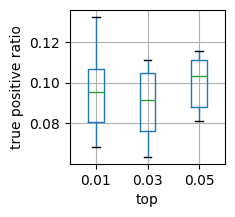

None

In [8]:
for model_random_seed, df_tnr in dict_df_tnr.items():
    display(f'Random seed = {model_random_seed}')
    fig, ax = plt.subplots(figsize=(2,2))
    df_tnr.boxplot(ax=ax)
    ax.set_xlabel('top')
    ax.set_ylabel('true positive ratio')
    display(plt.show())

### precision recall curve

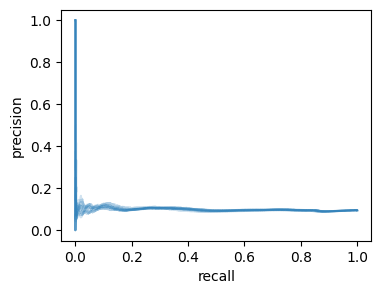

In [9]:
fig, ax = plt.subplots(figsize=(4,3))
for model_random_seed, _dict_eval_results in dict_eval_results.items():
    for datset_random_seed, dict_eval_result in _dict_eval_results['eval_results'].items():
        x = dict_eval_result['precision_recall_curve']['recall']
        y = dict_eval_result['precision_recall_curve']['precision']
        ax.plot(x,y, alpha=0.2, color='C0')
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')

### analysis
この分析ではRecallに着目する．
すなわち，本来誤りであるのにも関わらず検知されないトリプルに着目し，なぜそれが検知されない（スコアが大きい/小さくない）のか，トリプルの特徴に着目して分析する．

In [10]:
model_random_seed = 0
dataset_random_seet = 1
top = 0.05
df = dict_eval_results[model_ramdon_seed]['eval_results'][datset_random_seed]['false_dataset']
threshold = dict_eval_results[model_ramdon_seed]['eval_results'][datset_random_seed]['true_positive_ratio'][top]['threashold']

In [11]:
dict_df = {}
dict_df['true-positive'] = df[(df['score']>threshold)&(df['is-error']==False)]
dict_df['false-positive'] = df[(df['score']>threshold)&(df['is-error']==True)]
dict_df['false-negative'] = df[(df['score']<threshold)&(df['is-error']==False)]
dict_df['true-negative'] = df[(df['score']<threshold)&(df['is-error']==True)]

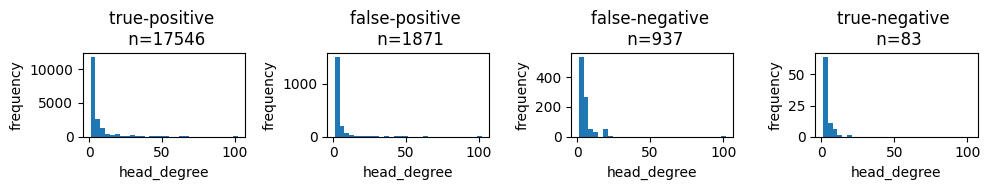

None

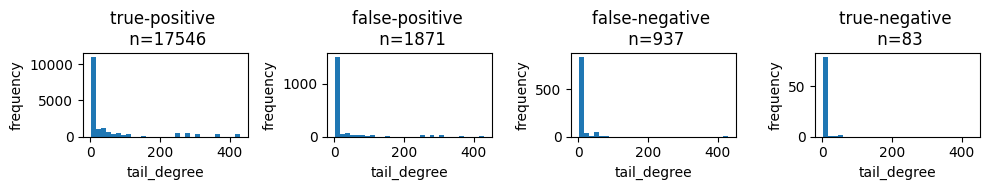

None

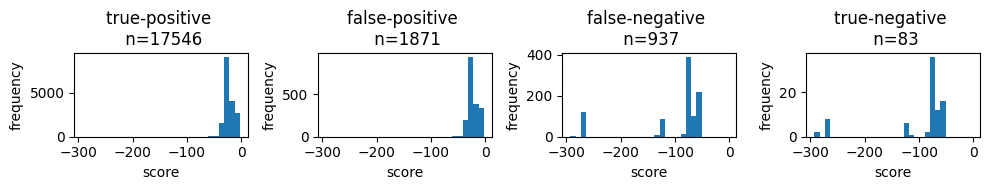

None

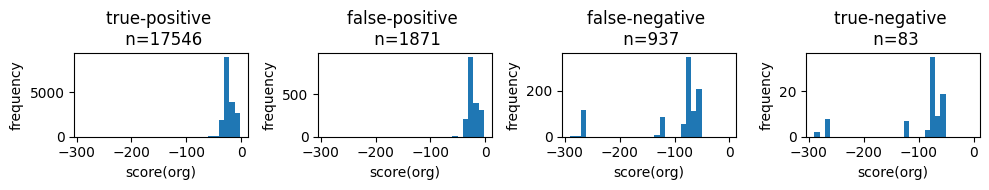

None

In [12]:
numeric_cols = ['head_degree', 'tail_degree', 'score', 'score(org)']
n = len(dict_df)
for col in numeric_cols:

    display(HTML(f'<h3>{col}</h3>'))
    
    vmin = np.min([df[col].min() for df in dict_df.values()])
    vmax = np.max([df[col].max() for df in dict_df.values()])
    
    fig, axs = plt.subplots(ncols=n, sharex=True, figsize=(10,2))
    i = 0
    for _type, df in dict_df.items():
        axs[i].hist(df[col].values, label=_type, range=(vmin, vmax),bins=30)
        axs[i].set_title(f'{_type} \n n={len(df)}')
        axs[i].set_xlabel(col)
        axs[i].set_ylabel('frequency')
        i += 1
    fig.tight_layout()
    display(plt.show())